C:\Users\Perydox\AppData\Local\Temp\ipykernel_8924\4163283693.py:58: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_m[c].fillna(df_m[c].mean(), inplace=True)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Mejores hiperparámetros: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

Test MAE : 2,446.92
Test RMSE: 2,916.50
Test R²  : 0.7115
Modelo guardado como modelo_final_2025_brutos.joblib

Predicciones en Test:

   fecha_mes  actual_income  predicted_income
0 2021-05-01        24000.0      26863.635895
1 2022-01-01        22600.0      23380.251852
2 2022-08-01        34770.0      34594.224518
3 2023-01-01        35290.0      33915.367504
4 2023-02-01        23880.0      26898.199801
5 2023-03-01        19800.0      23089.696567
6 2023-04-01        26000.0      28000.158526
7 2024-02-01        26530.0      30236.147039
8 2024-05-01        21000.0      26900.081065
9 2024-08-01        33280.0      31919.397724

Proyección 2025:

    fecha_mes  predicted_income
0  2025-01-01      27586.530952
1  2025-02-01      27499.068059
2  2025-03-01      31611.668435
3  2025-04-01

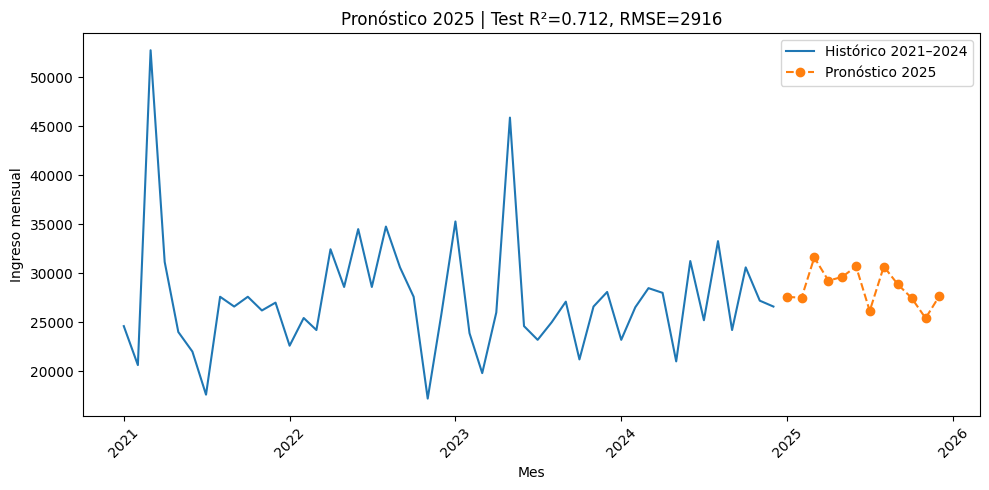

In [1]:
# modelo_prediccion_final_corregido.py

import os
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib
path_data = r"C:\Users\Perydox\Desktop\Proyecto_Grado - copia\data\Datos_final"
atenciones = pd.read_csv(
    os.path.join(path_data, "atenciones_final.csv"),
    header=None,
    names=['atencion_id','paciente_id','tratamiento_id','fecha','forma_pago','estado_pago','extra'],
    parse_dates=['fecha']
).drop(columns=['extra'])
tratamientos = pd.read_csv(
    os.path.join(path_data, "tratamientos_final.csv"),
    header=None,
    names=['tratamiento_id','treatment_name','area_id','precio'],
    dtype={'precio': float}
)

df = atenciones.merge(
    tratamientos[['tratamiento_id','precio']],
    on='tratamiento_id', how='left'
)
df['ingreso'] = np.where(df['estado_pago']=="Pagado", df['precio'], 0.0)

# 2) Ingeniería de variables mensuales
df['anio'] = df['fecha'].dt.year
df['mes']  = df['fecha'].dt.month

agg = df.groupby(['anio','mes']).agg(
    ingreso_total     = ('ingreso','sum'),
    total_atenciones  = ('atencion_id','count'),
    pacientes_unicos  = ('paciente_id', pd.Series.nunique),
    pct_pagado        = ('estado_pago', lambda s: np.mean(s=="Pagado"))
).reset_index()

agg['fecha_mes'] = pd.to_datetime(
    agg['anio'].astype(str) + '-' +
    agg['mes'].astype(str).str.zfill(2) + '-01'
)
agg = agg.sort_values('fecha_mes').reset_index(drop=True)

df_m = agg.copy()
df_m['sin_mes']   = np.sin(2*np.pi * (df_m['mes']-1)/12)
df_m['cos_mes']   = np.cos(2*np.pi * (df_m['mes']-1)/12)
df_m['anio_cent'] = df_m['anio'] - df_m['anio'].min()
df_m['lag1'] = df_m['ingreso_total'].shift(1)
df_m['lag2'] = df_m['ingreso_total'].shift(2)
df_m['ma3']  = df_m['ingreso_total'].rolling(3).mean().shift(1)

for c in ['lag1','lag2','ma3']:
    df_m[c].fillna(df_m[c].mean(), inplace=True)

# 4) Definir X, y y split
features = [
    'total_atenciones','pacientes_unicos','pct_pagado',
    'sin_mes','cos_mes','anio_cent','lag1','lag2','ma3'
]
X = df_m[features]
y = df_m['ingreso_total']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

# 5) Búsqueda de hiperparámetros con GridSearchCV
param_grid = {
    'n_estimators': [200, 500, 1000],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)
rf = grid.best_estimator_
print("Mejores hiperparámetros:", grid.best_params_)

# 6) Evaluación del modelo optimizado en test
y_pred = rf.predict(X_test)
mae   = mean_absolute_error(y_test, y_pred)
rmse  = np.sqrt(mean_squared_error(y_test, y_pred))
r2    = r2_score(y_test, y_pred)

print(f"\nTest MAE : {mae:,.2f}")
print(f"Test RMSE: {rmse:,.2f}")
print(f"Test R²  : {r2:.4f}")

if r2 >= 0.70:
    joblib.dump(rf, Path("models")/"modelo_final_2025_brutos.joblib")
    print("Modelo guardado como modelo_final_2025_brutos.joblib")
else:
    print("R² < 0.70; no se guarda el modelo.")

# 7) Tabla de predicción en test
pred_df = pd.DataFrame({
    'fecha_mes'       : df_m.loc[y_test.index,'fecha_mes'].values,
    'actual_income'   : y_test.values,
    'predicted_income': y_pred
})
pred_df = pred_df.sort_values('fecha_mes').reset_index(drop=True)
print("\nPredicciones en Test:\n")
print(pred_df)

# 8) Proyección de ingresos para 12 meses de 2025
future_idx = pd.date_range('2025-01-01','2025-12-01',freq='MS')
future = pd.DataFrame({'fecha_mes': future_idx})
future['anio'] = future['fecha_mes'].dt.year
future['mes']  = future['fecha_mes'].dt.month

hist_means = df_m.groupby(df_m['mes'])[features[:4]].mean()
for var in ['total_atenciones','pacientes_unicos','pct_pagado']:
    future[var] = future['mes'].map(hist_means[var])
future['sin_mes']   = np.sin(2*np.pi * (future['mes']-1)/12)
future['cos_mes']   = np.cos(2*np.pi * (future['mes']-1)/12)
future['anio_cent'] = future['anio'] - df_m['anio'].min()
for lag in ['lag1','lag2','ma3']:
    future[lag] = df_m[lag].iloc[-1]  

X_future = future[features]
future['predicted_income'] = rf.predict(X_future)

projection_df = future[['fecha_mes','predicted_income']].reset_index(drop=True)
print("\nProyección 2025:\n")
print(projection_df)

# 9) Gráfica histórico vs. pronóstico
plt.figure(figsize=(10,5))
plt.plot(df_m['fecha_mes'], df_m['ingreso_total'], label='Histórico 2021–2024')
plt.plot(future['fecha_mes'], future['predicted_income'], '--o', label='Pronóstico 2025')
plt.xlabel('Mes')
plt.ylabel('Ingreso mensual')
plt.title(f"Pronóstico 2025 | Test R²={r2:.3f}, RMSE={rmse:.0f}")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


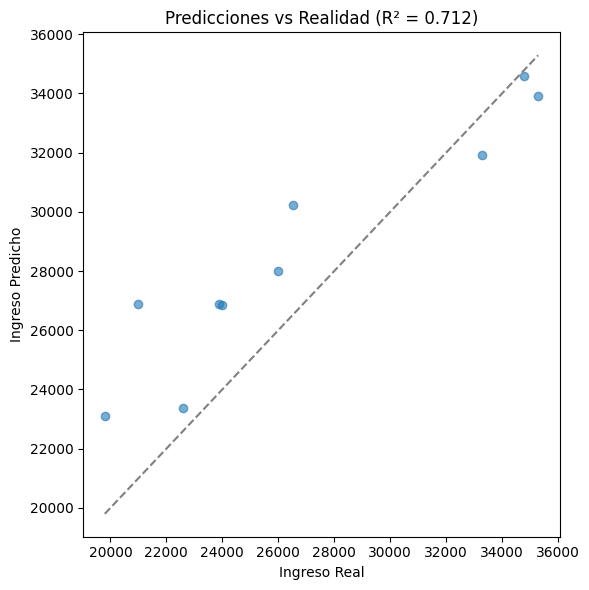

In [ ]:
# Celda 1: Scatter Plot Predicho vs Real 
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, linestyle='--', color='gray')
plt.xlabel('Ingreso Real')
plt.ylabel('Ingreso Predicho')
plt.title(f'Predicciones vs Realidad (R² = {r2:.3f})')
plt.tight_layout()
plt.show()


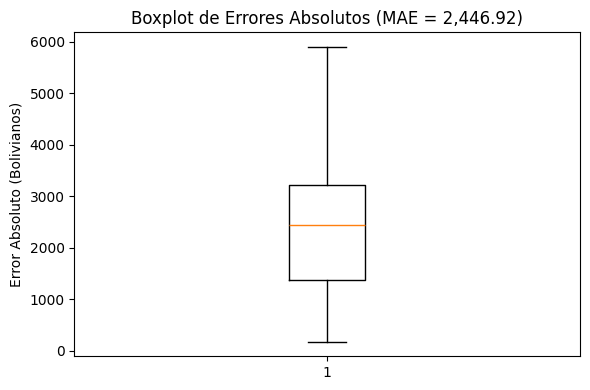

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Cálculo de errores absolutos
residuals = y_test - y_pred
errors_abs = np.abs(residuals)

plt.figure(figsize=(6,4))
plt.boxplot(errors_abs, vert=True)
plt.ylabel('Error Absoluto (Bolivianos)')
plt.title(f'Boxplot de Errores Absolutos (MAE = {mae:,.2f})')
plt.tight_layout()
plt.show()


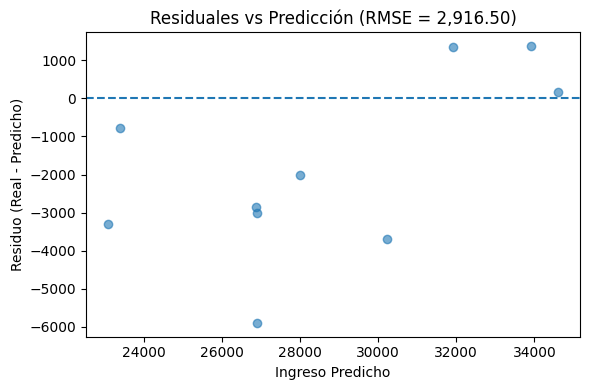

In [9]:
import matplotlib.pyplot as plt

residuals = y_test - y_pred

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, linestyle='--')
plt.xlabel('Ingreso Predicho')
plt.ylabel('Residuo (Real - Predicho)')
plt.title(f'Residuales vs Predicción (RMSE = {rmse:,.2f})')
plt.tight_layout()
plt.show()
